# Detecção de Fraudes em Pagamentos - PaySim

### Bibliotecas

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/datasetinf'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from ydata_profiling import ProfileReport
from IPython.display import display, HTML
import matplotlib.pyplot as plt

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

# check xgboost version
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/datasetinf/describe.csv
/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv


### Layout

In [32]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16,
    'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(rc=rc)
sns.set_style("darkgrid")
sns.set_palette("pastel")

### Configurações

In [33]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

# Define um valor maior para a largura máxima das colunas
pd.options.display.max_colwidth = 1000

seed = 42
np.random.seed(seed)

### Funções

In [34]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.figure(figsize=(4, 3))
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [35]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [36]:
def plot_feature_freq(df, feature, top_n=10):
    value_counts = df[feature].value_counts(dropna=True)
    top_values = value_counts.head(top_n)
    other_values_count = value_counts.iloc[top_n:].sum()

    if other_values_count > 0:
        top_values['Outros'] = other_values_count

    total = top_values.sum()

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')

    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        percentage = p.get_height() / total * 100
        ax.annotate('{:.1f}%'.format(percentage), (p.get_x() + p.get_width() / 2., 0),
                    ha='center', va='center', xytext=(0, -40), textcoords='offset points')

    ax.set(xlabel='isFraud', ylabel='Quantidade')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

***
# 1) Definição do problema e objetivo do projeto

## 1.1) Contexto

Apresentamos um conjunto de dados sintético gerado usando o simulador denominado PaySim como uma abordagem para tal problema. PaySim usa dados agregados do conjunto de dados privado para gerar um conjunto de dados sintético que se assemelha à operação normal das transações e injeta comportamento malicioso para avaliar posteriormente o desempenho dos métodos de detecção de fraude.

## 1.2) Sobre o Conteudo

PaySim simula transações de dinheiro móvel com base em uma amostra de transações reais extraídas de um mês de registros financeiros de um serviço de dinheiro móvel implementado em um país africano. Os registos originais foram fornecidos por uma empresa multinacional, fornecedora do serviço financeiro móvel que funciona atualmente em mais de 14 países em todo o mundo.

Este conjunto de dados sintético foi reduzido em 1/4 do conjunto de dados original e foi criado apenas para Kaggle.

## 1.1) Dicionario de dados

In [37]:
dicionario = pd.read_csv('/kaggle/input/datasetinf/describe.csv', delimiter=';', header=None, encoding='latin1', index_col=None)
dicionario

,0,1
0,step,"mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo equivale a 1 hora. Total de passos 744 (simulação de 30 dias)."
1,type,"CASH-IN, CASH-OUT, DÉBITO, PAGAMENTO e TRANSFERÊNCIA."
2,amount,valor da transação em moeda local.
3,nameOrig,cliente que iniciou a transação
4,oldbalanceOrg,saldo inicial antes da transação
5,newbalanceOrig,novo saldo após a transação.
6,nameDest,cliente que é o destinatário da transação
7,oldbalanceDest,destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
8,newbalanceDest,novo destinatário do saldo após a transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
9,isFraud,"São as transações realizadas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar assumindo o controle das contas dos clientes e tentando esvaziar os fundos transferindo para outra conta e depois sacando do sistema."


***
# 2) Coleta e preparação dos dados

## 2.1) Coleta dos dados - Modelagem

In [38]:
# treinamento
df = pd.read_csv('/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv')

# isFlaggedFraud foi excluido pois o modelo pode usar esta coluna como referencia para prever fraudes
df = df.drop(['isFlaggedFraud'],axis=1)

print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0


### Amostragem

Foi feita amostragem pelo fato que não é preciso usar todo data set para calcular feature importance, e também o dataset é muito grande (6 milhões de transações), sendo assim despenderia muito tempo e hardware

In [39]:
df.shape

(6362620, 10)

In [40]:
df = df.sample(frac=0.010, random_state=3)

In [41]:
df.shape

(63626, 10)

### Checar dados faltantes

In [42]:
just_check_nan(df)

Dados com NaN:
Series([], dtype: int64)

columns_with_nan.shape (0,)



## 2.2) Preparação dos dados

In [45]:
X = df.drop(['isFraud'], axis=1) # escolhidas Feature Importance - Criado em outro notebook

X

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
1605953,156,CASH_IN,165069.05,C250811032,4646166.16,4811235.21,C802273332,3217531.32,3052462.27
362350,17,CASH_OUT,255335.25,C223182924,72400.00,0.00,C3591085,219586.00,656216.23
870147,42,PAYMENT,2672.27,C2122111614,120676.58,118004.31,M2074777965,0.00,0.00
429440,18,PAYMENT,11100.20,C469474657,1196367.32,1185267.13,M1118001312,0.00,0.00
523247,20,CASH_IN,39524.17,C369747370,2667967.73,2707491.90,C1606131350,152341.22,112817.05
...,...,...,...,...,...,...,...,...,...
872340,42,CASH_OUT,163137.85,C440457083,0.00,0.00,C1357007794,1650737.52,1813875.36
228069,14,CASH_OUT,76384.31,C1742715847,55.00,0.00,C575888262,1179.00,22175.57
4947941,351,CASH_IN,187656.80,C1590936514,1811894.92,1999551.71,C734365862,939552.76,751895.96
1630162,157,PAYMENT,13590.11,C20459796,0.00,0.00,M1705813915,0.00,0.00


### 2.2.1) Seleção do Target

In [46]:
# define target
y = df['isFraud']

In [47]:
# contagem de classes
c_y = Counter(y)
c_y

Counter({0: 63545, 1: 81})

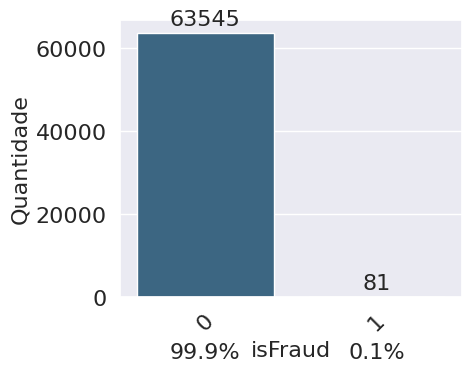

In [48]:
plot_feature_freq(df, 'isFraud')

### 2.2.2) Variaveis Categoricas

In [49]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  3
['type', 'nameOrig', 'nameDest']


### 2.2.3) Variaveis Numéricas

In [50]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  6
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


***
# 3) Modelagem

In [51]:
# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [52]:
# Dividindo as features em dados de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.7, 
                                                  random_state = 2048)

In [53]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_val.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(label_X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.fit_transform(label_X_valid[object_cols])

In [54]:
model = XGBClassifier(random_state=2048)
model.fit(label_X_train, y_train)
preds = model.predict(label_X_valid)

## 3.1) Cross Validation

In [56]:
scores = cross_validate(model, 
                        label_X_train, 
                        y_train, 
                        cv=5, 
                        scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))
# scores

In [57]:
print(scores['test_accuracy'])

[0.99895233 0.99895233 0.99947603 0.99869007 0.99973801]


In [58]:
print(scores['test_precision'])

[1.   0.75 0.8  0.   1.  ]


In [59]:
print(scores['test_recall'])

[0.33333333 0.5        0.8        0.         0.8       ]


In [60]:
print(scores['test_f1'])

[0.5        0.6        0.8        0.         0.88888889]


In [61]:
print(scores['test_roc_auc'])

[0.98325463 0.97153725 0.99947534 0.99900315 0.99438615]


***
# 4) Analise de features para o modelo

## 4.1) Feature Importance

In [62]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, n_iter=1000).fit(label_X_valid, y_val)
eli5.show_weights(perm, feature_names = label_X_valid.columns.tolist())

Weight,Feature
0.0006 ± 0.0002,oldbalanceOrg
0.0006 ± 0.0002,newbalanceOrig
0.0002 ± 0.0001,amount
0.0001 ± 0.0001,newbalanceDest
0.0001 ± 0.0000,step
0.0001 ± 0.0000,type
0.0001 ± 0.0001,nameDest
-0.0000 ± 0.0000,nameOrig
-0.0000 ± 0.0001,oldbalanceDest


## 4.2) SHAP Values

ExactExplainer explainer: 44540it [24:20, 30.28it/s]                           


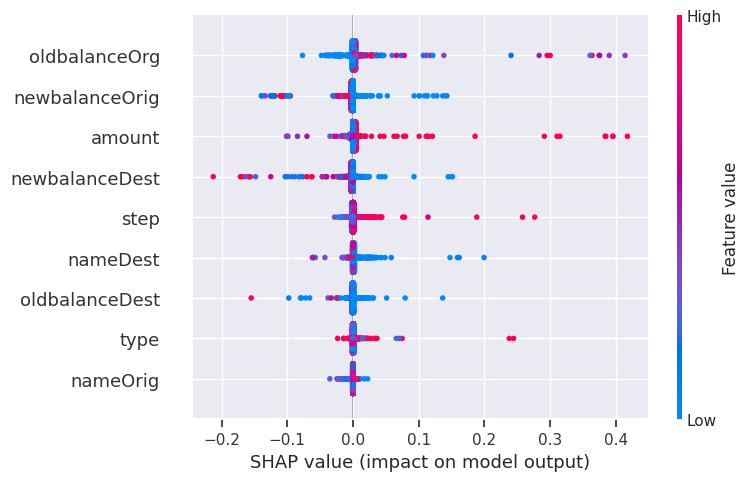

In [63]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.Explainer(model.predict, label_X_valid)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer(label_X_valid)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, label_X_valid)

## 4.3) Summary Plot

  0%|          | 0/4453 [00:00<?, ?it/s]

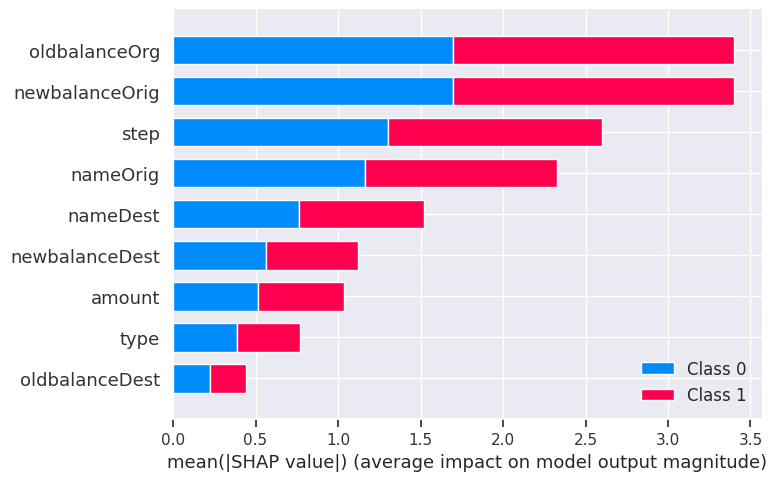

In [64]:
from shap import KernelExplainer, summary_plot

# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = label_X_train.sample(n=min(10, len(label_X_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = label_X_valid.sample(n=int((label_X_valid.shape[0] * 0.1)))

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model.predict_proba(pd.DataFrame(x, columns=label_X_train.columns))
explainer2 = KernelExplainer(predict, train_sample, link="logit")
shap_values2 = explainer2.shap_values(example, l1_reg=False)
summary_plot(shap_values2, example)
# summary_plot(shap_values, example, plot_type='violin', class_names=model.classes_)

## 4.4) Correlação (notebook 1_infra-dataset-analysis)
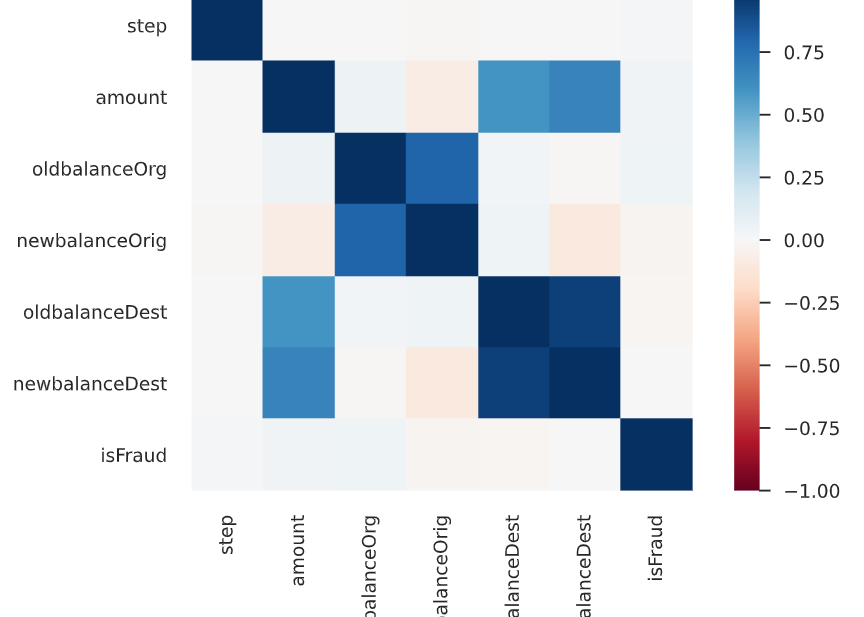

# 5) Conclusão desta análise

As features possuem: 
    - valores de feature importance bem proximos entre si e 
    - caracteristicas de Shap Values parecidos, 
    - olhando para as features, pouca correlação entre as features
    
Somando ao fato de haver poucas features no data set, não será necessário excluir nenhuma destas no treinamento do modelo